In [1]:
!python -V

Python 3.9.13


In [2]:
# !pip install lightgbm

### Imports

In [3]:
import pickle
import warnings
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [4]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [5]:
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn

**MLflow setup**

In [6]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("wallet-hub-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='wallet-hub-experiment', tags={}>

In [7]:
data_path = "data/dataset_00_with_header.csv"

In [8]:
df = pd.read_csv(data_path)

In [9]:
df.shape

(100000, 305)

### Data Cleaning

In [10]:
null_df = df.isnull().sum().to_frame('nulls')
null_df = null_df.sort_values(by=['nulls'], ascending=False )
null_df['percent_nulls'] = null_df['nulls']/df.shape[0]

In [11]:
# more than 55 percent null 
null_df = null_df[null_df['percent_nulls'] > 0.50]

In [12]:
null_columns = list(null_df.index)

In [13]:
df = df.drop(null_columns, axis=1)

In [14]:
df.shape

(100000, 286)

**Remove columns with too many zeros**

In [15]:
zeros_df = df[df == 0].count().to_frame('zeros_count')
zeros_df = zeros_df.sort_values(by=['zeros_count'], ascending=False)
zeros_df['percent_zeros'] = zeros_df['zeros_count']/df.shape[0]
zeros_df.head()

,zeros_count,percent_zeros
x067,100000,1.000
x096,100000,1.000
x094,100000,1.000
x095,100000,1.000
x060,99996,1.000


In [16]:
zeros_df = zeros_df[zeros_df['percent_zeros'] > 0.79]

In [17]:
zeros_columns = list(zeros_df.index)

In [18]:
df = df.drop(columns=zeros_columns)

In [19]:
df.shape

(100000, 129)

In [20]:
df = df.fillna(df.mean())

### Data Exploration

**target variable**

In [21]:
df['y'].describe()

count   100000.000
mean       619.198
std        118.462
min        300.000
25%        524.000
50%        599.000
75%        720.000
max        839.000
Name: y, dtype: float64

mu = 619.198 , sigma = 118.461


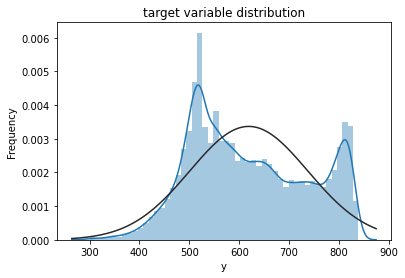

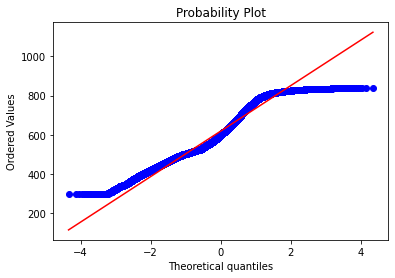

In [22]:
sns.distplot(df['y'], fit=norm)

(mu, sigma) = norm.fit(df['y'])
print(f"mu = {mu:.3f} , sigma = {sigma:.3f}")
plt.ylabel('Frequency')
plt.title('target variable distribution')

fig = plt.figure()
res = probplot(df['y'], plot=plt)

### Feature Selection

In [23]:
target = 'y'
features = df.columns[df.columns != target]

### Modelling

In [24]:
X = df[features].values
y = df[target].values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)


In [27]:
X_train.shape

(81000, 128)

In [28]:
X_val.shape

(9000, 128)

In [30]:
# stop here

#### Lasso regression

In [ ]:
with mlflow.start_run():
    mlflow.set_tag("model-type", "lasso")

    alpha=0.005
    mlflow.log_param("alpha", alpha)
    lasso = make_pipeline(
        RobustScaler(), 
        Lasso(alpha=alpha, random_state=1))
        
    lasso.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_train)
    rmse_lasso = np.sqrt(mean_squared_error(y_train, y_pred_lasso))
    r2_lasso = r2_score(y_train, y_pred_lasso)

    mlflow.log_metric("rmse", rmse_lasso)
    mlflow.log_metric("r2", r2_lasso)

In [ ]:
with open('models/lasso.pkl', 'wb') as f:
    pickle.dump(lasso, f)

#### ElasticNet

In [ ]:
with mlflow.start_run():
    mlflow.set_tag("model-type", "elastic-net")

    alpha=0.005
    l1_ratio = 0.9

    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)

    enet = make_pipeline(
        RobustScaler(), 
        ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=3))
    enet.fit(X_train, y_train)
    
    y_pred_enet = enet.predict(X_train)
    rmse_enet = np.sqrt(mean_squared_error(y_train, y_pred_enet))
    r2_enet = r2_score(y_train, y_pred_enet)

    mlflow.log_metric("rmse", rmse_enet)
    mlflow.log_metric("r2", r2_enet)

#### XGBoost

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        
        xgb_model = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50,
        )
        
        # xgb_model.fit(X_train, y_train)
        
        y_pred = xgb_model.predict(valid)
        rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred))
        r2_xgb = r2_score(y_val, y_pred)

        mlflow.log_metric('rmse', rmse_xgb)
        mlflow.log_metric('r2', r2_xgb)
    
    return {'loss': rmse_xgb, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 2000, 100)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'seed': 42
}

In [ ]:
best_result = fmin(
    fn=objective, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=20, 
    trials=Trials())

In [ ]:

with mlflow.start_run():
    mlflow.set_tag('model', 'xgboost')

    best_params = {
        "colsample_bytree": 0.5943780476579916,
        "learning_rate":	0.054120181998319354,
        "max_depth": 9,
        "min_child_weight":	12.47506339422273,
        "n_estimators":	1800,
        "reg_alpha":	0.017613900382780774,
        "reg_lambda":	0.003320031633641519,
        "seed":	42}
    
    mlflow.log_params(best_params)

    xgb_model = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50,
    )

    y_pred = xgb_model.predict(valid)
    rmse_xgb_best = np.sqrt(mean_squared_error(y_val, y_pred))
    r2_xgb_best = r2_score(y_val, y_pred)

    mlflow.log_metric('rmse', rmse_xgb_best)
    mlflow.log_metric('r2', r2_xgb_best)

    mlflow.xgboost.log_model(xgb_model, artifact_path='models_mlflow')

mlflow.end_run()

#### LightGBM

In [31]:
light_train = lgb.Dataset(X_train, label=y_train, params={"max_bin": 50})
light_valid = lgb.Dataset(X_val, label=y_val)

In [32]:
def lgb_objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'lightgbm')
        mlflow.log_params(params)

        model_lgb = lgb.train(
            params=params,
            train_set=light_train,
            num_boost_round=1000,
            valid_sets=light_valid,
            early_stopping_rounds=50
        )

        y_pred = model_lgb.predict(X_val)
        rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_pred))
        r2_lgbm = r2_score(y_val, y_pred)
        mlflow.log_metric('rmse', rmse_lgbm)
        mlflow.log_metric('r2', r2_lgbm)
    
    return {'loss': rmse_lgbm, 'status': STATUS_OK}

In [37]:
lgb_search_space = {
    # 'class_weight': hp.choice('class_weight', [None, 'balanced']),
    # 'boosting_type': hp.choice('boosting_type',
    #                             [{'boosting_type': 'gbdt'},
    #                              {'boosting_type': 'dart'},
    #                              {'boosting_type': 'goss'}]),
    'num_leaves': scope.int(hp.quniform('num_leaves', 8, 128, 2)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    # 'subsample_for_bin': scope.int(hp.quniform('subsample_for_bin', 20000, 300000, 20000)),
    # 'feature_fraction': hp.uniform('featuree_fraction', 0.5, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    # 'min_data_in_leaf': scope.int(hp.qloguniform('min_data_leaf', 0, 6, 1)),
    # 'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
    # 'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
    # 'verbose': -1,
    # 'subsample': None,
    # 'reg_alpha': None,
    # 'min_sum_hessian_in_leaf': hp.qloguniform('min_sum_hessian_in_leaf', 5, 11, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    # 'min_child_weight': hp.loguniform('min_child_weight', -16, 5),
    'objective': 'regression',
    # 'max_bin': 55,

}

In [39]:
lgb_best_result = fmin(
    fn=lgb_objective, 
    space=lgb_search_space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=Trials())

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4211                     
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 128
[LightGBM] [Info] Start training from score 619.102691
[1]	valid_0's l2: 11569.9                             
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 9694.22                             
[3]	valid_0's l2: 8164.98                             
[4]	valid_0's l2: 6904.18                             
[5]	valid_0's l2: 5909.84                             
[6]	valid_0's l2: 5056.33                             
[7]	valid_0's l2: 4380.98                             
[8]	valid_0's l2: 3825.86                             
[9]	valid_0's l2: 3364.67                             
[10]	valid_

In [ ]:
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)

In [ ]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=2200,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)